In [45]:
import h2o
import pandas as pd
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from sklearn.cross_validation import train_test_split
from sklearn import metrics

In [46]:
df_train = pd.read_csv("./new/train_data.csv")
df_test = pd.read_csv("./new/test_data.csv")

In [69]:
def run_gbm(x_train, label_train, x_valid = None, label_valid = None):

    h2o.remove_all()                          
    h2o.init(max_mem_size = "2G")             
    
    gbm = H2OGradientBoostingEstimator(
            ntrees=2000,
            learn_rate=0.05,
            max_depth=7,
            sample_rate=0.9,
            col_sample_rate=0.9,
            stopping_rounds=10,
            stopping_tolerance=0.0001, #10-fold increase in threshold as defined in rf_v1
            score_each_iteration=True,
            model_id="gbm_starter_1",
            seed=2000000
        )

    hf_train = h2o.H2OFrame(pd.concat([x_train, label_train], axis = 1))
    
    if x_valid is not None:
        
        gbm.train(hf_train.col_names[:-1], hf_train.col_names[-1], training_frame = hf_train)
        val_preds = gbm.predict(h2o.H2OFrame(x_valid))
        
        print metrics.roc_auc_score(label_valid, val_preds.as_data_frame())

    else:
        gbm.train(hf_train.col_names[:-1], hf_train.col_names[-1], training_frame = hf_train)
        
    return gbm

In [48]:
#Clean useless columns
df_label = df_train.pop("segment")
df_train.drop("ID", axis = 1, inplace=True)

#Validation split
x_train, x_valid, label_train, label_valid = train_test_split(df_train, df_label, test_size=0.2, random_state=4242, stratify = df_label)

test_ids = df_test.pop("ID")

In [49]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 16 mins
H2O cluster version:,3.10.4.8
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_belongtech_vnfu2a
H2O cluster total nodes:,1
H2O cluster free memory:,1.515 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [70]:
#Validation
gbm_model = run_gbm(x_train, label_train, x_valid, label_valid)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 36 mins
H2O cluster version:,3.10.4.8
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_belongtech_vnfu2a
H2O cluster total nodes:,1
H2O cluster free memory:,1.587 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
0.833214528811


In [71]:
#Testing
gbm_model = run_gbm(df_train, df_label)
gbm_preds = gbm_model.predict(h2o.H2OFrame(df_test))

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 44 mins
H2O cluster version:,3.10.4.8
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_belongtech_vnfu2a
H2O cluster total nodes:,1
H2O cluster free memory:,1.550 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


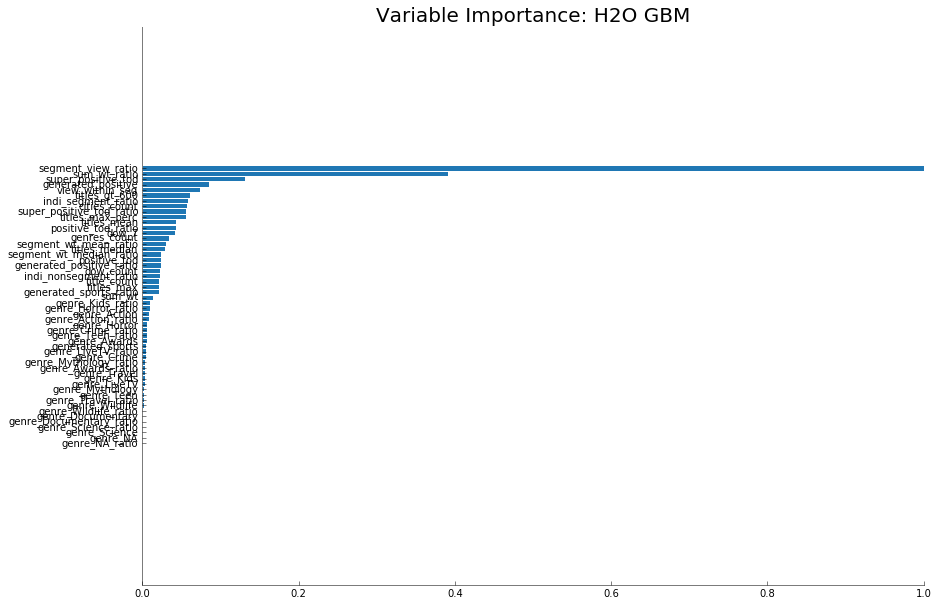

[]

In [74]:
gbm_model.varimp_plot()
import matplotlib.pyplot as plt
plt.plot()

In [73]:
sub = pd.DataFrame()
sub['ID'] = test_ids
sub['segment'] = gbm_preds.as_data_frame()
sub.to_csv("./subs/gbm_2.csv", index=False)   